# Загрузка данных

In [1]:
import json
import re
from joblib import delayed, Parallel

from razdel import sentenize, tokenize
from bpe import Encoder
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import traceback

In [2]:
def tokenize_(text):
    tokens = tokenize(text)
    return [_.text for _ in tokens]
    
def remove_tags(text):
    text  = re.sub("<.*?>", "", text).replace('\n', ' ').replace('&nbsp;', ' ').replace('&mdash;', ' ')
    return text

In [3]:
df = pd.read_csv('data/lenta.csv')
df['title'] = df['title'].apply(lambda x: str(x).replace('\xa0', ' '))
df['full_text'] = df['title'].map(lambda x: str(x) + ' ') + \
                df['text'].map(lambda x: str(x).replace('\n', ' '))
df[['full_text', 'tags']].to_csv('data/lenta_text.txt', index=False, sep='|')

In [4]:
VOCAB_SIZE = 30000
encoder = Encoder(VOCAB_SIZE, word_tokenizer=tokenize_) 
encoder = encoder.load('bpe_enc')

In [8]:
tags = df['tags'].value_counts()
tags = tags[tags>100]
tags = tags[tags<34_000].map(str)
with open('data/tags.txt', 'w', encoding='UTF-8') as f:
    f.write('\n'.join(tags.index.tolist()))
    
tags = tags.index.tolist()

In [5]:
topics = df['topic'].value_counts()
topics = topics[topics>100]
topics = topics.index.tolist()

# Модель

In [6]:
import tensorflow as tf

In [7]:
maxlen = 60

def gen_train(df_params):
#     df_params = df_params.sample(frac=1)
    texts = df_params['full_text'].values
    y = df_params['topic'].values
    for line, label in zip(texts, y):
        try:
            idxs = list(encoder.transform([line.strip()]))[0]
        except:
            print(traceback.format_exc())
            continue
        len_idxs = len(idxs)
        if len_idxs<maxlen:
            idxs = idxs + [0]*(maxlen-len_idxs)
        c_step = len_idxs//maxlen
        label = topics.index(label)
        #for i in range(c_step):
        yield idxs[:maxlen], maxlen, label


def parser(input_seq, len_seq, y):
    return {'input_seq':input_seq, 'len_seq': len_seq}, y


def input_fn(df, params, is_training):
    dataset = tf.data.Dataset.from_generator(lambda: gen_train(df),
                                             (tf.int64,tf.int64,tf.int64),
                                              output_shapes=(tf.TensorShape([None]), 
                                                             tf.TensorShape([]),
                                                            tf.TensorShape([])))
    if is_training:
        dataset = dataset.repeat(count=params['num_epochs'])
        dataset = dataset.shuffle(params['buffer_size'])
    dataset = dataset.batch(params['batch_size'])
    dataset = dataset.map(parser)
    return dataset.make_one_shot_iterator().get_next()


In [8]:
# encoder
def build_model(features, params, is_training):
    
    # Embedding matrix
    bpe_emb_matrix = tf.get_variable('bpe_embedding_matrix',
                                 shape=[params['vocab_size'], params['emb_size']],
                                 dtype=tf.float32,
                                    trainable=params['trainable_emb'])

    def encode(x):
        # embedding
        embs = tf.nn.embedding_lookup(bpe_emb_matrix, x['input_seq'])
        # dropout
        dropout_emb = tf.layers.dropout(inputs=embs, 
                                        rate=0.1, 
                                        training=is_training)
        # lstm
        lstm_cell_1 = tf.nn.rnn_cell.GRUCell(250)
        outputs, final_states = tf.nn.dynamic_rnn(
            lstm_cell_1, dropout_emb, sequence_length=x['len_seq'], dtype=tf.float32)

        
        max_pool = tf.reduce_max(input_tensor=outputs, axis=1)
        mean_pool = tf.reduce_mean(input_tensor=outputs, axis=1)
        concat_pools = tf.concat((mean_pool, max_pool, final_states),1)
        
        
        
        return concat_pools

    
    with tf.variable_scope('encoder'):
        logits = encode(features)
    
    return logits


In [9]:
def model_fn(features, labels, mode, params):
    
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    with tf.variable_scope('model'):
        concat_pools = build_model(features, params, is_training)
    
    if params['do_transferlearning']:
        keys = ['model/encoder']
        tf.train.init_from_checkpoint('ckpt/ulmfit_st2_experiment_15/', {k+'/': k+'/' for k in keys})
    
        
    dropout_pools = tf.layers.dropout(inputs=concat_pools, 
                                        rate=0.1, 
                                        training=is_training)
    dense = tf.layers.dense(dropout_pools, 100)
    dropout_dense = tf.layers.dropout(inputs=dense, 
                                    rate=0.1, 
                                    training=is_training)
    logits = tf.layers.dense(dropout_dense, params['num_classes'])
    if mode == tf.estimator.ModeKeys.PREDICT:
        class_nums = tf.argmax(logits,1)
        probas = tf.nn.softmax(logits)
        predictions = {'y':class_nums, 'probas':probas}
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    loss_clf = tf.losses.sparse_softmax_cross_entropy(labels, logits)
    
    global_step = tf.train.get_global_step()
    train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_clf, global_step)

    
    return tf.estimator.EstimatorSpec(mode, loss=loss_clf, train_op=train_op)



In [10]:
def get_estimator(count_samples):
    tf.reset_default_graph()

    model_dir = f'ckpt/08_ulmfit_clf_experiment_{count_samples}'


    config = tf.estimator.RunConfig(tf_random_seed=123,
                                    model_dir=model_dir,
                                    save_summary_steps=5,
                                   save_checkpoints_steps=1000)

    estimator = tf.estimator.Estimator(model_fn,
                                       params=model_params,
                                       config=config)
    return estimator

In [11]:
def get_data(c_samples, mode='train', label_col='tags', labels=None):
    dfs = []
    for label in labels:
        if mode == 'train':
            tmp_df = df[df[label_col]==label][:c_samples]
        elif mode == 'half_train':
            tmp_df = df[df[label_col]==label]
            tmp_df = tmp_df[:len(tmp_df)//2]
        elif mode == 'half_test':
            tmp_df = df[df[label_col]==label]
            tmp_df = tmp_df[len(tmp_df)//2:len(tmp_df)//2 + 20]
        else:
            tmp_df = df[df[label_col]==label][100:120]
        dfs.append(tmp_df)
    return pd.concat(dfs)
       
from sklearn.metrics import roc_auc_score
def mean_roc_auc(y_true, y_pred, class_list=None):
    y = np.array(y_true.copy())
    probas = np.array(y_pred.copy())
    rs = []
    for i in range(len(class_list)):
        r = roc_auc_score((y==i).astype(int), probas[:, i])
        rs.append(r)
    return np.mean(rs)

In [12]:
aucs = []
for c_samples in range(5, 101, 5):
# c_samples = 100
    bs = 32
    ep = 1
    model_params = {
        'vocab_size': VOCAB_SIZE,
        'emb_size': 100,
        'batch_size': bs,
        'num_epochs': ep,
        'max_step': ep*(c_samples*len(topics))//bs,
        'num_classes': len(topics)
    }

    model_params['do_transferlearning'] = True 
    model_params['trainable_emb'] = True

    df_train = get_data(c_samples,label_col='topic', labels=tuple(topics))

    #     model_params['num_epochs'] = int(model_params['num_epochs']* (1 - c_samples/max_c_samples)) + 1
    print(len(df_train), model_params['num_epochs'])

    model_params['buffer_size'] = len(df_train)
    estimator = get_estimator(c_samples)
    estimator.train(input_fn=lambda: input_fn(df_train, model_params, True))

    # eval
    df_test = get_data(c_samples, mode='test', label_col='topic', labels=tuple(topics))

    y_pred = estimator.predict(input_fn=lambda: input_fn(df_test, model_params, False))
    y_pred = [_ for _ in tqdm(y_pred)]

    auc = mean_roc_auc(df_test['topic'].map(lambda x: topics.index(x)), [_['probas'] for _ in y_pred],
                      class_list=tuple(topics))
    print(c_samples, auc)
    aucs.append(auc)

90 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_5', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000273893C2EB8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_5\model.ckpt-3
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

5 0.5156459489983617
180 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_10', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.traini

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_10\model.ckpt-6
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

10 0.5430508031555936
270 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_15', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002738BBA5E80>, '_task_type': 'worker', '_ta

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_15\model.ckpt-9
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

15 0.5776691714609996
360 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_20', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000027389830908>, '_task_type': 'worker', '_ta

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_20\model.ckpt-12
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

20 0.5887905211984994
450 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_25', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002738BE88E80>, '_task_type': 'worker', '_t

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_25\model.ckpt-15
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

25 0.5996963356200764
540 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_30', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002738BAAA518>, '_task_type': 'worker', '_t

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_30\model.ckpt-17
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

30 0.6228201859586151
630 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_35', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002738BD4C470>, '_task_type': 'worker', '_t

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_35\model.ckpt-20
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

35 0.6296274397982746
720 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_40', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002739F71BCF8>, '_task_type': 'worker', '_t

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_40\model.ckpt-23
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

40 0.6507504598645846
810 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_45', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002739F815278>, '_task_type': 'worker', '_t

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_45\model.ckpt-26
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

45 0.6549156588783218
900 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_50', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002739F61A2E8>, '_task_type': 'worker', '_t

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_50\model.ckpt-29
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

50 0.68659669456605
990 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_55', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000027389787F28>, '_task_type': 'worker', '_tas

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_55\model.ckpt-31
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

55 0.6801281890001509
1080 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_60', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000273C791EA20>, '_task_type': 'worker', '_

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_60\model.ckpt-34
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

60 0.7176692133939404
1170 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_65', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002738BB688D0>, '_task_type': 'worker', '_

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_65\model.ckpt-37
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

65 0.726053145809222
1260 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_70', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000027389AC4518>, '_task_type': 'worker', '_t

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_70\model.ckpt-40
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

70 0.7219322559363066
1350 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_75', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002738982CCF8>, '_task_type': 'worker', '_

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_75\model.ckpt-43
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

75 0.7431063643022079
1440 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_80', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000273AB0A0A90>, '_task_type': 'worker', '_

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_80\model.ckpt-45
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

80 0.7409707895134101
1530 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_85', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002738BF7EB70>, '_task_type': 'worker', '_

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_85\model.ckpt-48
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

85 0.7486886870516671
1620 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_90', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002739F9DCF60>, '_task_type': 'worker', '_

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_90\model.ckpt-51
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

90 0.7655049145406666
1710 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_95', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002738BE32CC0>, '_task_type': 'worker', '_

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_95\model.ckpt-54
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

95 0.7769288453904516
1800 1
INFO:tensorflow:Using config: {'_model_dir': 'ckpt/08_ulmfit_clf_experiment_100', '_tf_random_seed': 123, '_save_summary_steps': 5, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000273C7B8F390>, '_task_type': 'worker', '

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/08_ulmfit_clf_experiment_100\model.ckpt-57
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

100 0.7832343017047139


In [21]:
df_test = get_data(0, mode='half_test', label_col='topic', labels=tuple(topics))

y_pred = estimator.predict(input_fn=lambda: input_fn(df_test, model_params, False))
y_pred = [_ for _ in tqdm(y_pred)]

mean_roc_auc(df_test['topic'].map(lambda x: topics.index(x)), [_['probas'] for _ in y_pred],
            class_list=tuple(topics))


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpt/11_clf_experiment_100\model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.



0.9469199346405228

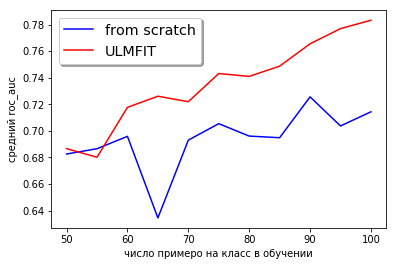

In [19]:
scr_aucs =  [0.5724317122058405, 0.6070560908994337,0.6299123042430544,0.6705657662266504,0.6818705026920948,0.715760356038623,0.6883202782110849,
 0.6883007095053589,0.6484353422007526,0.6825647724159524,0.6865449073841114,0.6958691859977524,0.6344690171477773,0.693003768373617,0.7054034438126549,
 0.6960583035609453,0.6948188357179199,0.7255667935837009,0.7036803144411458,0.7143219862795417]
plt.plot(list(range(50,101, 5)), scr_aucs[9:], 'b-', label='from scratch')

plt.plot(list(range(50,101, 5)), aucs[9:], 'r-', label='ULMFIT')
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel('число примеро на класс в обучении')
plt.ylabel('средний roc_auc')
plt.show()

In [14]:
aucs

[0.5156459489983617,
 0.5430508031555936,
 0.5776691714609996,
 0.5887905211984994,
 0.5996963356200764,
 0.6228201859586151,
 0.6296274397982746,
 0.6507504598645846,
 0.6549156588783218,
 0.68659669456605,
 0.6801281890001509,
 0.7176692133939404,
 0.726053145809222,
 0.7219322559363066,
 0.7431063643022079,
 0.7409707895134101,
 0.7486886870516671,
 0.7655049145406666,
 0.7769288453904516,
 0.7832343017047139]